# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 200     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1924.79736328125
iteration 0 loss 368.2161865234375


iteration 5000 loss 0.2086256742477417


iteration 10000 loss 0.10447731614112854


iteration 15000 loss 0.9828898906707764


iteration 20000 loss 0.05379970744252205


iteration 25000 loss 0.044887661933898926


iteration 30000 loss 0.03852810710668564


iteration 35000 loss 0.03340274095535278


iteration 40000 loss 0.02979251556098461


iteration 45000 loss 0.02703816071152687


iteration 50000 loss 0.02457050234079361


iteration 55000 loss 0.02314799092710018


iteration 60000 loss 0.0211574025452137


iteration 65000 loss 0.01966865174472332


iteration 70000 loss 0.01837623305618763


iteration 75000 loss 0.01727430894970894


iteration 80000 loss 0.01659986563026905


iteration 85000 loss 0.015807274729013443


iteration 90000 loss 0.014904818497598171


iteration 95000 loss 0.014257161878049374


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.01382825244218111


iteration 105000 loss 0.013412294909358025


iteration 110000 loss 0.012982423417270184


iteration 115000 loss 0.0125183816999197


iteration 120000 loss 0.012147469446063042


iteration 125000 loss 0.011803960427641869


iteration 130000 loss 0.01148825790733099


iteration 135000 loss 0.011200390756130219


iteration 140000 loss 0.010929755866527557


iteration 145000 loss 0.010676955804228783


iteration 150000 loss 0.011348471976816654


iteration 155000 loss 0.010219048708677292


iteration 160000 loss 0.009998824447393417


iteration 165000 loss 0.00979961734265089


iteration 170000 loss 0.00961182452738285


iteration 175000 loss 0.009430218487977982


iteration 180000 loss 0.010603061877191067


iteration 185000 loss 0.009103634394705296


iteration 190000 loss 0.008963336236774921


iteration 195000 loss 0.00886488240212202


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00867273099720478


iteration 205000 loss 0.0086078941822052


iteration 210000 loss 0.00845818780362606


iteration 215000 loss 0.008330274373292923


iteration 220000 loss 0.008197663351893425


iteration 225000 loss 0.008078408427536488


iteration 230000 loss 0.007962848991155624


iteration 235000 loss 0.007851443253457546


iteration 240000 loss 0.007744621019810438


iteration 245000 loss 0.00764252245426178


iteration 250000 loss 0.007731968536973


iteration 255000 loss 0.007452172692865133


iteration 260000 loss 0.0073590511456131935


iteration 265000 loss 0.007270688656717539


iteration 270000 loss 0.0071832891553640366


iteration 275000 loss 0.007096806075423956


iteration 280000 loss 0.007012317422777414


iteration 285000 loss 0.006936064921319485


iteration 290000 loss 0.00686210161074996


iteration 295000 loss 0.006783730816096067


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0067183454521000385


iteration 305000 loss 0.00668465718626976


iteration 310000 loss 0.006584532093256712


iteration 315000 loss 0.006487618200480938


iteration 320000 loss 0.006394119001924992


iteration 325000 loss 0.00630395021289587


iteration 330000 loss 0.00621679425239563


iteration 335000 loss 0.006132608745247126


iteration 340000 loss 0.006051169242709875


iteration 345000 loss 0.005971614737063646


iteration 350000 loss 0.00589488260447979


iteration 355000 loss 0.005820078309625387


iteration 360000 loss 0.005747593007981777


iteration 365000 loss 0.005677255801856518


iteration 370000 loss 0.005608401261270046


iteration 375000 loss 0.005541336257010698


iteration 380000 loss 0.005476202815771103


iteration 385000 loss 0.0054126097820699215


iteration 390000 loss 0.0053505804389715195


iteration 395000 loss 0.0052900612354278564


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.005231200251728296


iteration 405000 loss 0.005219228100031614


iteration 410000 loss 0.0052027092315256596


iteration 415000 loss 0.0051866513676941395


iteration 420000 loss 0.005170896183699369


iteration 425000 loss 0.005155362654477358


iteration 430000 loss 0.005140041932463646


iteration 435000 loss 0.005124926567077637


iteration 440000 loss 0.005109966732561588


iteration 445000 loss 0.005095162894576788


iteration 450000 loss 0.00508048664778471


iteration 455000 loss 0.005065957549959421


iteration 460000 loss 0.005051554646342993


iteration 465000 loss 0.005037276074290276


iteration 470000 loss 0.005023111589252949


iteration 475000 loss 0.005009043961763382


iteration 480000 loss 0.004995105788111687


iteration 485000 loss 0.004981263540685177


iteration 490000 loss 0.00496751070022583


iteration 495000 loss 0.004953867755830288


L2 loss -- Plot

loss -54.63571548461914


loss -189.34396362304688


loss -269.904541015625


loss -336.8255920410156


loss -391.8033752441406


loss -436.99432373046875


loss -473.758056640625


loss -503.6070861816406


loss -528.0009765625


loss -547.91015625


loss -563.9637451171875


loss -576.648681640625


loss -586.4520263671875


loss -593.8353881835938


loss -599.2062377929688


loss -602.9267578125


loss -605.344482421875


loss -606.7991943359375


loss -607.60009765625


loss -607.998046875


loss -608.1716918945312


loss -608.2352905273438


loss -608.253662109375


loss -608.2574462890625


loss -608.2579345703125


loss -608.2579956054688


loss -608.2579956054688


loss -608.258056640625


loss -608.258056640625


loss -608.258056640625


loss -608.258056640625


loss -608.258056640625


loss -608.2579956054688


loss -608.2579956054688


loss -608.2579956054688


loss -608.2579956054688


loss -608.258056640625


loss -608.2579956054688


loss -608.2579956054688


loss -608.2579956054688


final mse:  8.328184808448214e-10
max, min: 6.192876 -8.036216
loss -54.63571548461914


loss -191.46900939941406


loss -275.96246337890625


loss -347.916748046875


loss -407.896240234375


loss -457.8436584472656


loss -499.83233642578125


loss -534.7125854492188


loss -563.217041015625


loss -586.4320678710938


loss -605.3692626953125


loss -620.69873046875


loss -632.8609008789062


loss -642.2664184570312


loss -649.3213500976562


loss -654.4066772460938


loss -657.8978271484375


loss -660.1573486328125


loss -661.513671875


loss -662.2511596679688


loss -662.6033935546875


loss -662.7457275390625


loss -662.7918701171875


loss -662.802978515625


loss -662.8048095703125


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


loss -662.8050537109375


final mse:  1.0405882822084322e-09
max, min: 7.884211 -8.175605


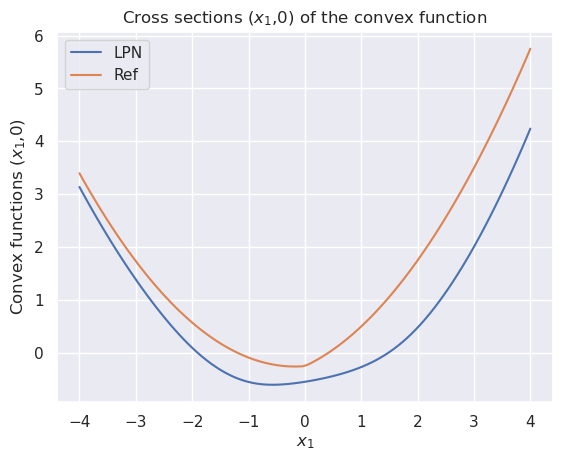

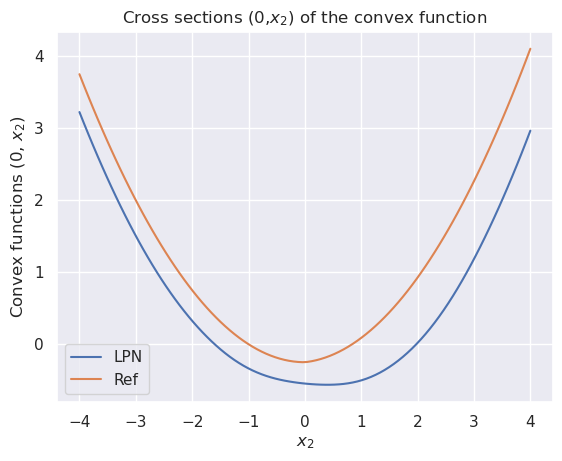

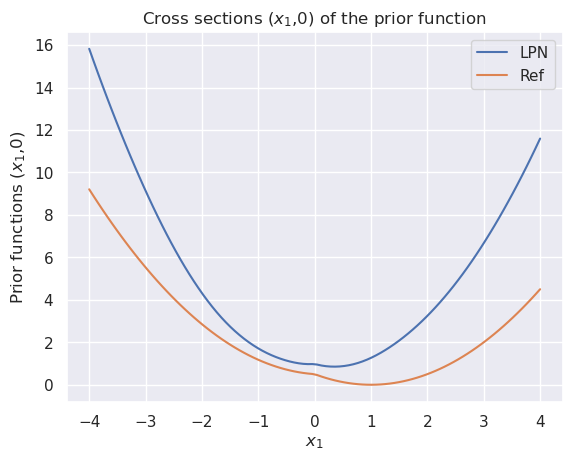

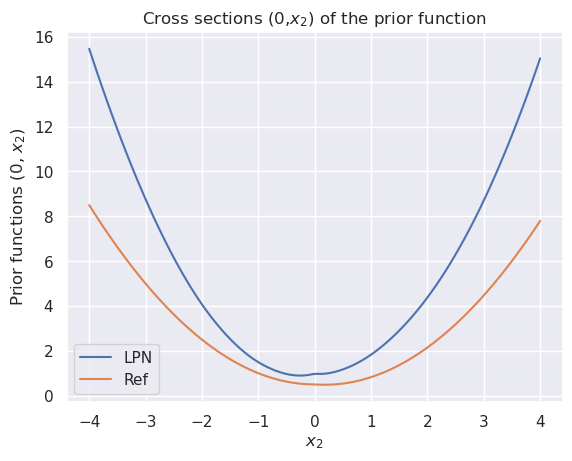

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1694.66357421875
iteration 0 loss 795.239501953125


iteration 5000 loss 5.132471561431885


iteration 10000 loss 0.27680227160453796


iteration 15000 loss 0.13468153774738312


iteration 20000 loss 0.09972240030765533


iteration 25000 loss 0.08357131481170654


iteration 30000 loss 0.07368531078100204


iteration 35000 loss 0.06640473753213882


iteration 40000 loss 0.06080355495214462


iteration 45000 loss 0.056221652776002884


iteration 50000 loss 0.05246352404356003


iteration 55000 loss 0.04920683056116104


iteration 60000 loss 0.046320755034685135


iteration 65000 loss 0.04375500604510307


iteration 70000 loss 0.04144098237156868


iteration 75000 loss 0.03939031437039375


iteration 80000 loss 0.03755391016602516


iteration 85000 loss 0.035911817103624344


iteration 90000 loss 0.034351248294115067


iteration 95000 loss 0.03280284255743027


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.03120107389986515


iteration 105000 loss 0.030295858159661293


iteration 110000 loss 0.02885480225086212


iteration 115000 loss 0.027513500303030014


iteration 120000 loss 0.026287151500582695


iteration 125000 loss 0.02515791356563568


iteration 130000 loss 0.02455693669617176


iteration 135000 loss 0.02317788638174534


iteration 140000 loss 0.02230246178805828


iteration 145000 loss 0.02146906591951847


iteration 150000 loss 0.020721184089779854


iteration 155000 loss 0.02003011293709278


iteration 160000 loss 0.01938537321984768


iteration 165000 loss 0.018759923055768013


iteration 170000 loss 0.01818831078708172


iteration 175000 loss 0.017658846452832222


iteration 180000 loss 0.01716214045882225


iteration 185000 loss 0.01670782081782818


iteration 190000 loss 0.016283316537737846


iteration 195000 loss 0.01586928963661194


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.015483526512980461


iteration 205000 loss 0.015332930721342564


iteration 210000 loss 0.014919107779860497


iteration 215000 loss 0.01453154906630516


iteration 220000 loss 0.014170507900416851


iteration 225000 loss 0.01383043173700571


iteration 230000 loss 0.013510020449757576


iteration 235000 loss 0.013204909861087799


iteration 240000 loss 0.012913873419165611


iteration 245000 loss 0.012636378407478333


iteration 250000 loss 0.012370764277875423


iteration 255000 loss 0.012116776779294014


iteration 260000 loss 0.011875980533659458


iteration 265000 loss 0.011645970866084099


iteration 270000 loss 0.011424627155065536


iteration 275000 loss 0.011212185025215149


iteration 280000 loss 0.011008339934051037


iteration 285000 loss 0.010812623426318169


iteration 290000 loss 0.010624160058796406


iteration 295000 loss 0.010441831313073635


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.010266442783176899


iteration 305000 loss 0.010236836969852448


iteration 310000 loss 0.010199404321610928


iteration 315000 loss 0.010163388215005398


iteration 320000 loss 0.010128268040716648


iteration 325000 loss 0.010093833319842815


iteration 330000 loss 0.010059965774416924


iteration 335000 loss 0.010026611387729645


iteration 340000 loss 0.009993682615458965


iteration 345000 loss 0.009961158968508244


iteration 350000 loss 0.009928987361490726


iteration 355000 loss 0.00989715289324522


iteration 360000 loss 0.00986563228070736


iteration 365000 loss 0.00983438454568386


iteration 370000 loss 0.009803393855690956


iteration 375000 loss 0.0097726471722126


iteration 380000 loss 0.00974215380847454


iteration 385000 loss 0.009711897000670433


iteration 390000 loss 0.009681867435574532


iteration 395000 loss 0.009652039036154747


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.009622414596378803


iteration 405000 loss 0.009619554504752159


iteration 410000 loss 0.009616682305932045


iteration 415000 loss 0.009613833390176296


iteration 420000 loss 0.009611009620130062


iteration 425000 loss 0.009608207270503044


iteration 430000 loss 0.0096054095774889


iteration 435000 loss 0.009602625854313374


iteration 440000 loss 0.009599856100976467


iteration 445000 loss 0.009597083553671837


iteration 450000 loss 0.009594332426786423


iteration 455000 loss 0.009591592475771904


iteration 460000 loss 0.009588854387402534


iteration 465000 loss 0.009586123749613762


iteration 470000 loss 0.009583402425050735


iteration 475000 loss 0.009580682031810284


iteration 480000 loss 0.009577978402376175


iteration 485000 loss 0.009575278498232365


iteration 490000 loss 0.0095725879073143


iteration 495000 loss 0.009569899179041386


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


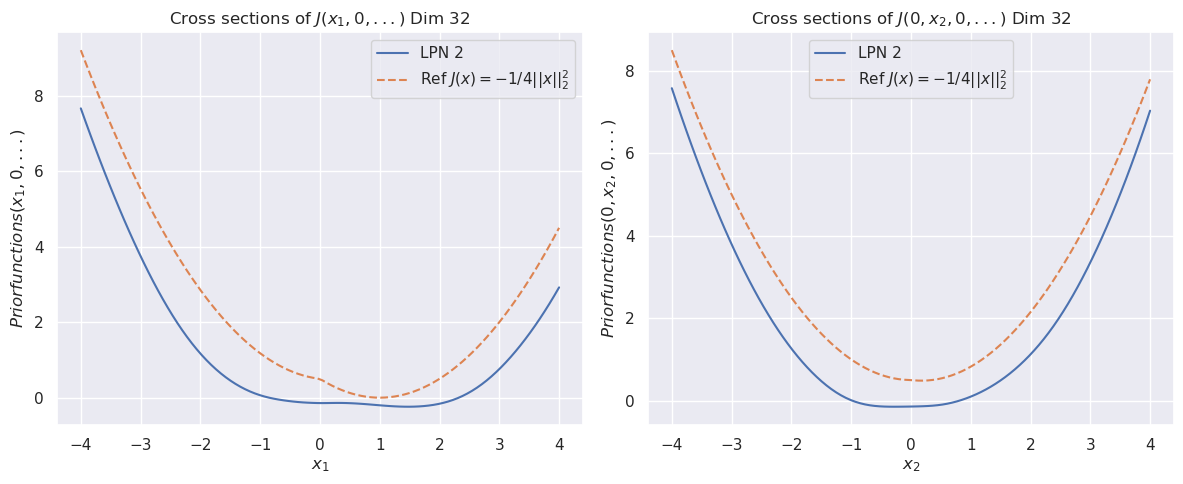

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)